# NHL Data Pipeline
This notebook contains the three core components for downloading, building, and verifying the NHL dataset.

**Files:**
1. `download_dataset.py`: Fetches raw JSON data from ESPN APIs.
2. `build_dataset.py`: Flattens JSON into a CSV and adds feature engineering (Rolling stats, etc.).
3. `verify_dataset.py`: Checks data integrity and generates visualization.

# Downloading the dataset

This is a public API provided by ESPN, and I am not affiliated with ESPN or responsible for any usage of this API. This information is provided solely for educational and informational purposes. Please use this API responsibly and abide by ESPN's terms of service.

In [3]:
import os
import json
import requests
import datetime
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, List, Any, Optional

START_DATE = "20241001"
END_DATE = "20250630"
OUTPUT_DIR = "data"
CHUNK_DAYS = 7
MAX_THREADS = 10
SCOREBOARD_URL = "http://site.api.espn.com/apis/site/v2/sports/hockey/nhl/scoreboard"
SUMMARY_URL = "http://site.api.espn.com/apis/site/v2/sports/hockey/nhl/summary"
TIMEOUT_SECONDS = 10

def generate_date_chunks(start_str: str, end_str: str, chunk_size_days: int) -> List[str]:
    """
    Splits a date range into smaller chunks formatted as string ranges.

    Args:
        start_str (str): Start date in YYYYMMDD format.
        end_str (str): End date in YYYYMMDD format.
        chunk_size_days (int): Number of days per chunk.

    Returns:
        List[str]: A list of date range strings (e.g., '20241001-20241007').
    """
    start = datetime.datetime.strptime(start_str, "%Y%m%d")
    end = datetime.datetime.strptime(end_str, "%Y%m%d")
    chunks = []
    current = start
    while current <= end:
        chunk_end = current + datetime.timedelta(days=chunk_size_days - 1)
        if chunk_end > end:
            chunk_end = end
        s_fmt = current.strftime("%Y%m%d")
        e_fmt = chunk_end.strftime("%Y%m%d")
        chunks.append(f"{s_fmt}-{e_fmt}")
        current = chunk_end + datetime.timedelta(days=1)
    return chunks

def extract_team_stats(team_data: Dict[str, Any], header_info: Dict[str, Any]) -> Dict[str, Any]:
    """
    Parses raw team dictionary to extract flattened statistics and record info.

    Args:
        team_data (Dict[str, Any]): Raw team data from the boxscore.
        header_info (Dict[str, Any]): lookup dictionary containing scores and records.

    Returns:
        Dict[str, Any]: A flat dictionary of team attributes and statistics.
    """
    team_id = team_data.get('team', {}).get('id')
    
    stats_list = team_data.get('statistics', [])
    stats_map = {item['name']: item['displayValue'] for item in stats_list}

    team_header = header_info.get(team_id, {})

    return {
        'team_id': team_id,
        'team_name': team_data.get('team', {}).get('displayName'),
        'home_away': team_data.get('homeAway'),
        'score': team_header.get('score', 0),
        'winner': team_header.get('winner', False),
        'record_summary': team_header.get('record', ''),
        'shots': stats_map.get('shotsTotal'),
        'power_play_goals': stats_map.get('powerPlayGoals'),
        'power_play_opportunities': stats_map.get('powerPlayOpportunities'),
        'faceoff_win_pct': stats_map.get('faceoffPercent'),
        'hits': stats_map.get('hits'),
        'blocked_shots': stats_map.get('blockedShots'),
        'pim': stats_map.get('penaltyMinutes'),
        'giveaways': stats_map.get('giveaways'),
        'takeaways': stats_map.get('takeaways')
    }

def fetch_game_summary(game_id: str) -> Optional[Dict[str, Any]]:
    """
    Retrieves and parses detailed game summary data from the API.

    Args:
        game_id (str): The unique identifier for the game event.

    Returns:
        Optional[Dict[str, Any]]: Parsed game data dictionary or None if failed.
    """
    url = f"{SUMMARY_URL}?event={game_id}"
    try:
        response = requests.get(url, timeout=TIMEOUT_SECONDS)
        if response.status_code == 200:
            data = response.json()
            
            header_map = {}
            competitions = data.get('header', {}).get('competitions', [{}])[0]
            date = competitions.get('date')
            
            for comp in competitions.get('competitors', []):
                t_id = comp.get('team', {}).get('id')
                record = next((r.get('summary') for r in comp.get('record', []) if r.get('type') == 'total'), "0-0-0")
                
                header_map[t_id] = {
                    'score': comp.get('score'),
                    'winner': comp.get('winner', False),
                    'record': record
                }

            game_info = {
                'game_id': game_id,
                'date': date,
                'venue': data.get('gameInfo', {}).get('venue', {}).get('fullName'),
                'attendance': data.get('gameInfo', {}).get('attendance')
            }

            pickcenter = data.get('pickcenter', [])
            if pickcenter:
                primary_pick = pickcenter[0]
                game_info['spread'] = primary_pick.get('spread')
                game_info['over_under'] = primary_pick.get('overUnder')
                
                home_odds = primary_pick.get('homeTeamOdds', {})
                away_odds = primary_pick.get('awayTeamOdds', {})
                if home_odds.get('favorite'):
                    game_info['favorite_moneyline'] = home_odds.get('moneyLine')
                else:
                    game_info['favorite_moneyline'] = away_odds.get('moneyLine')

            season_series = data.get('seasonseries', [])
            if season_series:
                series_data = season_series[0]
                game_info['season_series_summary'] = series_data.get('summary')
                game_info['season_series_competitors'] = series_data.get('competitors')
            
            officials = data.get('gameInfo', {}).get('officials', [])
            game_info['officials'] = [
                {'name': o.get('displayName'), 'position': o.get('position', {}).get('name')} 
                for o in officials
            ]

            teams_boxscore = data.get('boxscore', {}).get('teams', [])
            teams_stats = []
            for team in teams_boxscore:
                teams_stats.append(extract_team_stats(team, header_map))
            
            game_info['teams_stats'] = teams_stats
            
            return game_info
            
        return None
    except Exception:
        return None

def process_date_chunk(date_range: str) -> None:
    """
    Downloads and saves game data for a specific date range.

    Args:
        date_range (str): The date range string (YYYYMMDD-YYYYMMDD).

    Returns:
        None
    """
    file_path = os.path.join(OUTPUT_DIR, f"nhl_detailed_{date_range}.json")
    if os.path.exists(file_path):
        return

    scoreboard_url = f"{SCOREBOARD_URL}?dates={date_range}"
    game_ids = []
    
    try:
        sb_response = requests.get(scoreboard_url, timeout=TIMEOUT_SECONDS)
        if sb_response.status_code == 200:
            sb_data = sb_response.json()
            events = sb_data.get('events', [])
            game_ids = [event['id'] for event in events]
        else:
            return
    except Exception:
        return

    if not game_ids:
        return

    detailed_games = []
    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        future_to_game = {executor.submit(fetch_game_summary, gid): gid for gid in game_ids}
        
        for future in as_completed(future_to_game):
            result = future.result()
            if result:
                detailed_games.append(result)

    if detailed_games:
        with open(file_path, "w") as f:
            json.dump(detailed_games, f, indent=2)

if __name__ == "__main__":
    # Ensure directory exists
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    chunks = generate_date_chunks(START_DATE, END_DATE, CHUNK_DAYS)
    print(f"Downloading data in {len(chunks)} chunks...")
    
    for i, chunk in enumerate(chunks):
        process_date_chunk(chunk)
        # Sleep briefly to be nice to API
        time.sleep(0.5) 
    print("Download complete.")

Download complete.


### Feature Engineering
This section processes the downloaded JSON files.

In [4]:
import os
import json
import pandas as pd
import numpy as np
from glob import glob
from typing import Any

DEFAULT_REST_DAYS = 3
MAX_REST_DAYS = 7
OUTLIER_QUANTILE = 0.99
ROLLING_WINDOWS = [3, 10]

NEUTRAL_SEASON_WIN_PCT = 0.45
NEUTRAL_SAVE_PCT = 0.91
NEUTRAL_RATE_METRIC = 0.50

def load_and_flatten_data(directory: str) -> pd.DataFrame:
    """
    Reads JSON files from a directory and flattens them into a pandas DataFrame.

    Args:
        directory (str): The path to the directory containing JSON data files.

    Returns:
        pd.DataFrame: A flattened DataFrame containing game and team statistics.
    """
    files = glob(os.path.join(directory, "*.json"))
    rows = []

    print(f"Processing {len(files)} files...")

    for file in files:
        try:
            with open(file, "r") as f:
                games_list = json.load(f)

            if not isinstance(games_list, list):
                continue

            for game in games_list:
                game_id = game.get("game_id")
                date = game.get("date")
                d_obj = pd.to_datetime(date)

                season = d_obj.year + 1 if d_obj.month > 8 else d_obj.year

                venue = game.get("venue", "Unknown")
                attendance = game.get("attendance", 0)

                spread = game.get("spread")
                over_under = game.get("over_under")
                moneyline = game.get("favorite_moneyline")

                season_series = game.get("season_series_summary", "")

                officials_str = "|".join([o.get("name", "") for o in game.get("officials", [])])

                teams = game.get("teams_stats", [])
                if len(teams) != 2:
                    continue

                s0, s1 = int(teams[0].get("score", 0)), int(teams[1].get("score", 0))
                teams[0]["won"], teams[1]["won"] = int(s0 > s1), int(s1 > s0)

                for team in teams:
                    def f(x: Any) -> float:
                        try: return float(x)
                        except: return 0.0

                    rows.append({
                        "game_id": game_id,
                        "date": d_obj,
                        "season": season,
                        "venue": venue,
                        "attendance": float(attendance),
                        "officials": officials_str,
                        "season_series": season_series,
                        "spread": str(spread),
                        "over_under": f(over_under),
                        "favorite_moneyline": f(moneyline),
                        "team_id": team.get("team_id"),
                        "team_name": team.get("team_name"),
                        "home_away": team.get("home_away"),
                        "team_record": team.get("record_summary",""),
                        "won": team["won"],
                        "score": int(team.get("score",0)),
                        "shots": f(team.get("shots")),
                        "power_play_goals": f(team.get("power_play_goals")),
                        "power_play_opportunities": f(team.get("power_play_opportunities")),
                        "faceoff_win_pct": f(team.get("faceoff_win_pct")),
                        "hits": f(team.get("hits")),
                        "blocked_shots": f(team.get("blocked_shots")),
                        "pim": f(team.get("pim")),
                        "giveaways": f(team.get("giveaways")),
                        "takeaways": f(team.get("takeaways")),
                    })

        except Exception:
            pass

    df = pd.DataFrame(rows).sort_values(["team_id","date"]).reset_index(drop=True)
    return df

def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates rolling statistics, lag features, and merges opponent data.

    Args:
        df (pd.DataFrame): The raw flattened DataFrame.

    Returns:
        pd.DataFrame: The processed DataFrame suitable for modeling.
    """
    print("\n=== Feature Engineering ===")
    df['date'] = pd.to_datetime(df['date'])
    
    # CHANGED: fillna(0.0) removed. Coerce errors to NaN, keep NaN as NaN.
    df['spread'] = pd.to_numeric(df['spread'], errors="coerce")
    
    df = df.sort_values(["team_id","season","date"])

    shifted = df.groupby(['team_id','season'])['won'].transform(lambda x: x.shift())
    df['cum_wins'] = shifted.cumsum().fillna(0)

    df['cum_games'] = df.groupby(['team_id','season']).cumcount()
    df['season_win_pct'] = (df['cum_wins'] / df['cum_games']).replace([np.inf,np.nan], NEUTRAL_SEASON_WIN_PCT)

    df['prev_date'] = df.groupby(['team_id','season'])['date'].shift(1)
    df['rest_days'] = (df['date'] - df['prev_date']).dt.days
    df['rest_days'] = df['rest_days'].fillna(DEFAULT_REST_DAYS).clip(upper=MAX_REST_DAYS)
    df.drop(columns=['prev_date'], inplace=True)

    stats = ["score","power_play_goals","power_play_opportunities","faceoff_win_pct",
             "hits","blocked_shots","shots","pim","giveaways","takeaways"]
    
    for col in stats:
        df[col] = df[col].clip(upper=df[col].quantile(OUTLIER_QUANTILE))

    for w in ROLLING_WINDOWS:
        rolled = (
            df.groupby(['team_id','season'])[stats]
              .rolling(w, min_periods=1, closed='left').mean()
              .reset_index(drop=True)
        )
        rolled.columns = [f"rolling_{c}_{w}" for c in stats]
        df = pd.concat([df, rolled], axis=1)

        df[f"rolling_pp_efficiency_{w}"] = \
            df[f"rolling_power_play_goals_{w}"] / (df[f"rolling_power_play_opportunities_{w}"] + 1e-6)

    df = df.replace([np.inf,-np.inf], np.nan)

    print("Merging opponent joins...")
    opp = df[[
        "game_id","team_id","team_name","won","rest_days","season_win_pct","score","shots",
        *[f"rolling_{s}_{w}" for s in stats for w in ROLLING_WINDOWS],
        *[f"rolling_pp_efficiency_{w}" for w in ROLLING_WINDOWS]
    ]].copy()

    opp.columns = [c if c=="game_id" else f"opp_{c}" for c in opp.columns]

    df = df.merge(opp, on="game_id")
    df = df[df.team_id != df.opp_team_id]

    df['save_pct'] = np.where(
        df['opp_shots'] > 0,
        (df['opp_shots'] - df['opp_score']) / df['opp_shots'],
        NEUTRAL_SAVE_PCT
    )

    df['is_home'] = (df['home_away']=="home").astype(int)
    df['rest_advantage'] = df['rest_days'] - df['opp_rest_days']

    cols = list(df.columns)
    cols.insert(0, cols.pop(cols.index("won")))
    df = df[cols]

    return df

if __name__ == "__main__":
    df_raw = load_and_flatten_data("./data")
    if not df_raw.empty:
        df_final = build_features(df_raw)
        df_final.to_csv("nhl_dataset.csv", index=False)
        print(f"Success. Saved {len(df_final)} rows.")
    else:
        print("No data found.")

Processing 38 files...

=== Feature Engineering ===
Merging opponent joins...
Success. Saved 2886 rows.


### Verification
This section generates sanity check plots and verifies columns.

Loading nhl_dataset.csv
Sample row check (Leakage): {'rolling_score_3': nan, 'score': 4}


/var/folders/y2/8yp864p50kqfdc9p6cr66nch0000gn/T/ipykernel_63780/2345728411.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='won', data=df, palette=[NHL_PALETTE["silver"], NHL_PALETTE["orange"]])


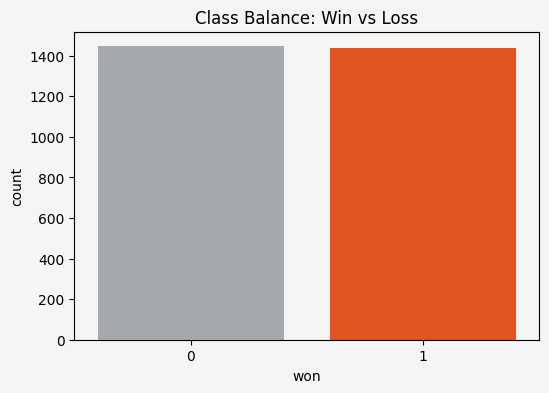

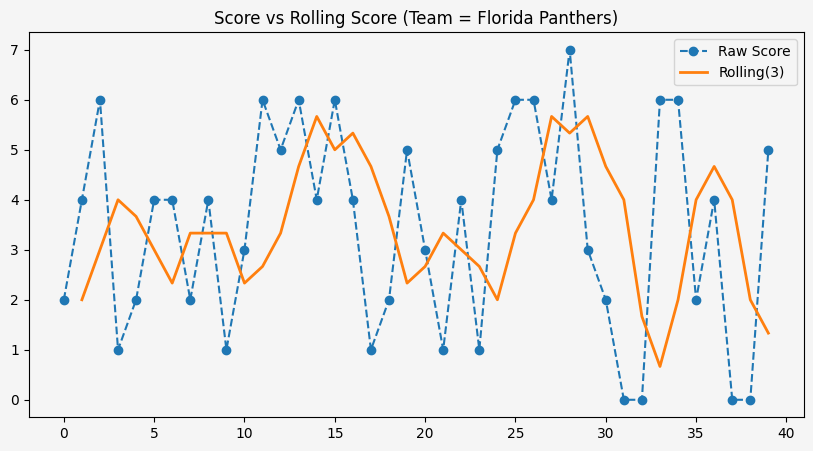

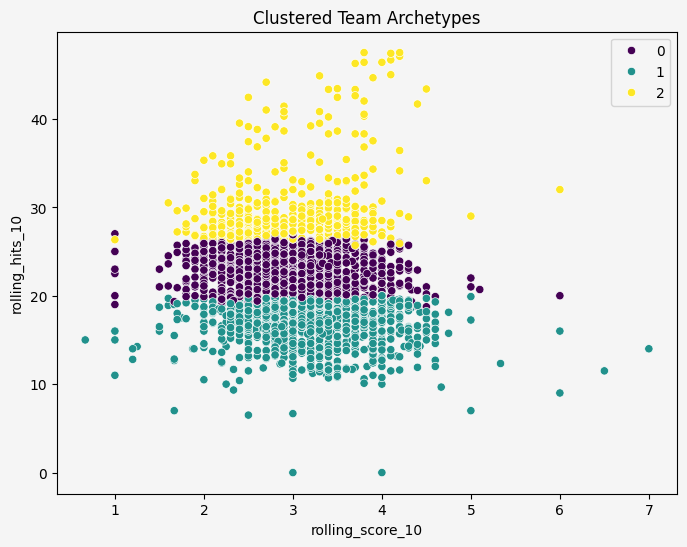

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

NHL_PALETTE = {
    "black": "#111111", "silver": "#A2AAAD", "orange": "#FF4600",
    "white": "#FFFFFF", "bg": "#F5F5F5"
}

def verify_dataset(file_path: str = "nhl_dataset.csv") -> None:
    """
    Loads the dataset, checks for integrity, and generates visualization charts.

    Args:
        file_path (str): Path to the CSV dataset.

    Returns:
        None
    """
    print(f"Loading {file_path}")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("File not found.")
        return

    # Check for leakage
    if "rolling_score_3" in df.columns:
        first = df.iloc[0][["rolling_score_3","score"]]
        print("Sample row check (Leakage):", first.to_dict())

    # Setup Plotting
    plt.rcParams.update({'figure.facecolor': NHL_PALETTE["bg"], 'axes.facecolor': NHL_PALETTE["bg"]})

    # 1. Class Balance
    plt.figure(figsize=(6,4))
    sns.countplot(x='won', data=df, palette=[NHL_PALETTE["silver"], NHL_PALETTE["orange"]])
    plt.title("Class Balance: Win vs Loss")
    plt.show()

    # 2. Rolling Window Check
    sample_team = df['team_name'].mode()[0]
    subset = df[df.team_name == sample_team].sort_values("date").iloc[:40]

    plt.figure(figsize=(10,5))
    plt.plot(subset['score'].reset_index(drop=True), label="Raw Score", linestyle='--', marker='o')
    if "rolling_score_3" in subset.columns:
        plt.plot(subset['rolling_score_3'].reset_index(drop=True), label="Rolling(3)", linewidth=2)
    plt.legend()
    plt.title(f"Score vs Rolling Score (Team = {sample_team})")
    plt.show()

    # 3. Clusters
    cluster_features = ["rolling_score_10","rolling_hits_10","rolling_pim_10"]
    cluster_features = [c for c in cluster_features if c in df.columns]

    if len(cluster_features) == 3:
        cluster_df = df[cluster_features].dropna()
        if len(cluster_df) >= 50:
            kmeans = KMeans(n_clusters=3, random_state=42)
            labels = kmeans.fit_predict(cluster_df)
            
            plt.figure(figsize=(8,6))
            sns.scatterplot(data=cluster_df, x="rolling_score_10", y="rolling_hits_10",
                            hue=labels, palette="viridis")
            plt.title("Clustered Team Archetypes")
            plt.show()

if __name__ == "__main__":
    verify_dataset()

# NHL Game Data (2024-2025): Advanced Metrics & Betting

![NHL Analytics](https://images.unsplash.com/photo-1515703407324-5f753afd8be8?q=80&w=1000&auto=format&fit=crop) 

# Disclaimer

This is a public API provided by ESPN, and I am not affiliated with ESPN or responsible for any usage of this API. This information is provided solely for educational and informational purposes. Please use this API responsibly and abide by ESPN's terms of service.

## Context
This dataset provides granular game-level statistics for the 2024-2025 NHL season. Unlike standard boxscore datasets, this dataset is preprocessed for Machine Learning. It includes rolling averages, rest day calculations, and opponent statistics joined onto each row, allowing for immediate time-series forecasting or classification modeling without extensive feature engineering.

The data is sourced from ESPN's public API and includes betting odds (spread, moneyline, over/under) to facilitate handicapping analysis.

## Content
The dataset follows a **Row-Per-Team** structure.
* **Total Rows:** approx 2,600 (Approx. 1,312 games * 2 teams)
* **Granularity:** Each row represents one team's performance/status for a specific game.
* **Leakage Prevention:** Rolling features use `closed='left'`, ensuring Game N only includes history up to Game N-1.

### Key Features
1. **Rolling Averages (3 & 10 games)** — scoring, shots, hits, penalties, and power play efficiency.
2. **Rest Tracking** — days since last game, plus rest advantage vs opponent.
3. **Opponent Features Included** — mirrored metrics for cross-team predictive modeling.
4. **Betting Lines Included** — closing spreads, totals, and moneylines.


## Data Dictionary

### Raw Game Statistics
| Column | Type | Description |
| :--- | :--- | :--- |
| `shots` | Float | Shots on goal in this game. |
| `power_play_goals` | Float | Power play goals scored. |
| `power_play_opportunities` | Float | Number of power play chances. |
| `faceoff_win_pct` | Float | Faceoff win percentage for the game. |
| `hits` | Float | Total hits recorded. |
| `blocked_shots` | Float | Shots blocked by this team. |
| `pim` | Float | Penalty minutes accumulated. |
| `giveaways` | Float | Giveaways committed. |
| `takeaways` | Float | Takeaways recorded. |

### Team Performance Features
| Column | Type | Description |
| :--- | :--- | :--- |
| `rest_days` | Float | Days since last game (capped at 7). |
| `rest_advantage` | Float | `rest_days - opp_rest_days`. |
| `season_win_pct` | Float | Win% to date (before this game). |
| `cum_wins` | Integer | Cumulative season wins prior to game. |
| `cum_games` | Integer | Games played to date in season. |
| `save_pct` | Float | Goalie save% for this specific game. |
| `is_home` | Binary | `1` = Home, `0` = Away. |
| `team_record` | String | Win-Loss-OT record at time of game. |

---

### Rolling Averages (3-Game Window)
| Column | Type | Description |
| :--- | :--- | :--- |
| `rolling_score_3` | Float | Avg goals scored over previous 3 games. |
| `rolling_power_play_goals_3` | Float | Avg PP goals (3-game window). |
| `rolling_power_play_opportunities_3` | Float | Avg PP chances (3-game window). |
| `rolling_faceoff_win_pct_3` | Float | Avg faceoff win% (3-game window). |
| `rolling_hits_3` | Float | Avg hits (3-game window). |
| `rolling_blocked_shots_3` | Float | Avg blocked shots (3-game window). |
| `rolling_shots_3` | Float | Avg shots on goal (3-game window). |
| `rolling_pim_3` | Float | Avg penalty minutes (3-game window). |
| `rolling_giveaways_3` | Float | Avg giveaways (3-game window). |
| `rolling_takeaways_3` | Float | Avg takeaways (3-game window). |
| `rolling_pp_efficiency_3` | Float | PP Goals / PP Opps (3-game window). |

---

### Rolling Averages (10-Game Window)
| Column | Type | Description |
| :--- | :--- | :--- |
| `rolling_score_10` | Float | Avg goals scored over previous 10 games. |
| `rolling_power_play_goals_10` | Float | Avg PP goals (10-game window). |
| `rolling_power_play_opportunities_10` | Float | Avg PP chances (10-game window). |
| `rolling_faceoff_win_pct_10` | Float | Avg faceoff win% (10-game window). |
| `rolling_hits_10` | Float | Avg hits (10-game window). |
| `rolling_blocked_shots_10` | Float | Avg blocked shots (10-game window). |
| `rolling_shots_10` | Float | Avg shots on goal (10-game window). |
| `rolling_pim_10` | Float | Avg penalty minutes (10-game window). |
| `rolling_giveaways_10` | Float | Avg giveaways (10-game window). |
| `rolling_takeaways_10` | Float | Avg takeaways (10-game window). |
| `rolling_pp_efficiency_10`| Float | PP Goals / PP Opps (10-game window). |

---

### Opponent Features
All opponent metrics mirror the team's features with an `opp_` prefix:

| Column | Type | Description |
| :--- | :--- | :--- |
| `opp_team_id` | Integer | Opponent's team identifier. |
| `opp_team_name` | String | Opponent's team name. |
| `opp_won` | Binary | Whether opponent won (`1`) or lost (`0`). |
| `opp_rest_days` | Float | Opponent's days since last game. |
| `opp_season_win_pct` | Float | Opponent's win% to date. |
| `opp_score` | Integer | Goals scored by opponent. |
| `opp_shots` | Float | Opponent's shots on goal. |
| `opp_rolling_score_3` | Float | Opponent's 3-game avg goals. |
| `opp_rolling_score_10` | Float | Opponent's 10-game avg goals. |
| `opp_rolling_power_play_goals_3` | Float | Opponent's 3-game PP goals avg. |
| `opp_rolling_power_play_goals_10` | Float | Opponent's 10-game PP goals avg. |
| `opp_rolling_power_play_opportunities_3` | Float | Opponent's 3-game PP opps avg. |
| `opp_rolling_power_play_opportunities_10` | Float | Opponent's 10-game PP opps avg. |
| `opp_rolling_faceoff_win_pct_3` | Float | Opponent's 3-game faceoff% avg. |
| `opp_rolling_faceoff_win_pct_10` | Float | Opponent's 10-game faceoff% avg. |
| `opp_rolling_hits_3` | Float | Opponent's 3-game hits avg. |
| `opp_rolling_hits_10` | Float | Opponent's 10-game hits avg. |
| `opp_rolling_blocked_shots_3` | Float | Opponent's 3-game blocked shots avg. |
| `opp_rolling_blocked_shots_10` | Float | Opponent's 10-game blocked shots avg. |
| `opp_rolling_shots_3` | Float | Opponent's 3-game shots avg. |
| `opp_rolling_shots_10` | Float | Opponent's 10-game shots avg. |
| `opp_rolling_pim_3` | Float | Opponent's 3-game PIM avg. |
| `opp_rolling_pim_10` | Float | Opponent's 10-game PIM avg. |
| `opp_rolling_giveaways_3` | Float | Opponent's 3-game giveaways avg. |
| `opp_rolling_giveaways_10` | Float | Opponent's 10-game giveaways avg. |
| `opp_rolling_takeaways_3` | Float | Opponent's 3-game takeaways avg. |
| `opp_rolling_takeaways_10` | Float | Opponent's 10-game takeaways avg. |
| `opp_rolling_pp_efficiency_3` | Float | Opponent's 3-game PP efficiency. |
| `opp_rolling_pp_efficiency_10` | Float | Opponent's 10-game PP efficiency. |

---

## Methodology

1. **Ingested via ESPN API** using `requests`.
2. **Flattened boxscores** into tabular rows.
3. **Derived labels** (`won`, cumulative win tracking).
4. **Feature engineering**:
   * Rolling windows via `groupby().rolling().shift(1)`
   * Opponent joins applied row-wise
   * Betting NaNs preserved to avoid bias

---

## Inspiration — Projects to Explore
- Predict **win probability** vs Vegas moneyline  
- Forecast **total goals** to beat market O/U  
- Analyze **fatigue impact** via rest differential  
- Cluster teams based on physical vs offensive profile  
- Add the is playoff game column

---

### Acknowledgements
Publicly available data courtesy of ESPN.  
Dataset intended for educational + analytical research.

